# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn
df_merge = pd.merge(df_offers, df_transactions, how='outer')
    # do an outer join
df_pivot = pd.pivot_table(df_merge, values = 'n', columns=['offer_id'], index=['customer_name'])
    # create picot table
df_pivot = df_pivot.fillna(0) # fill na with 0s

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Low values of SS likely represent better clusterings because a lower SS indicates less variation between data points to their mean centroid, so a better fit of the model to the data.

In [5]:
# Import packages
import numpy as np
from sklearn.cluster import KMeans

# Create a matrix called x_cols
x_cols = df_pivot.to_numpy() # create numpy array first
x_cols = np.matrix(x_cols) # then create a matrix

k_vals = range(2, 11) # k vals should be between 2 and 11

saved_values = [] # to save the values for laters

# Go thorugh all the k values
for k in k_vals: # for each value of k
    model = KMeans(n_clusters = k, random_state=33) # k means for that k
    model.fit(x_cols) # fit the data to the columns
    new_df = pd.DataFrame({'k': k, 'inertia': model.inertia_}, index=[0])
        # make a new df 
    saved_values.append(new_df) # append the values
    
saved_values = pd.concat(saved_values).reset_index(drop=True)
    # concat to save the values as a pd dataframe

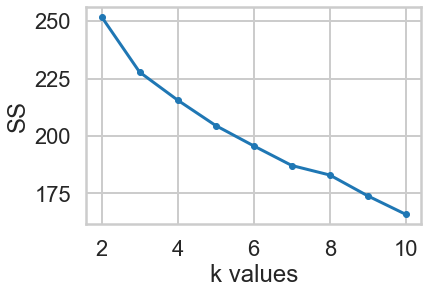

In [6]:
plt.plot(saved_values['k'], saved_values['inertia'], linestyle='solid', marker='.')
    # plot the data as a scatter plot with a line
plt.xlabel('k values') # xlabel 
plt.ylabel('SS') # ylabel
plt.show() #show the plot

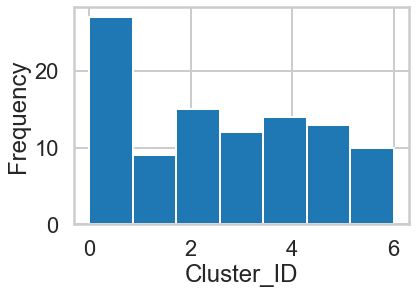

In [7]:
# Let's say that a k value of 7 is sufficient 
model = KMeans(n_clusters = 7)  # redo the model
model.fit(x_cols) # fit the model
predicted = model.predict(x_cols) # predict the model

# Plot the histogram
plt.hist(predicted, bins=7) # 7 bins because 6 possible values
plt.xlabel('Cluster_ID') # xlabel
plt.ylabel('Frequency') # ylabel
plt.show() # plot 

There is no distinct k value that gives a nice 'elbow' effect. It is difficult to determine the appropriate k value for this model, because the sum of squares decreases with each k nearly the same.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

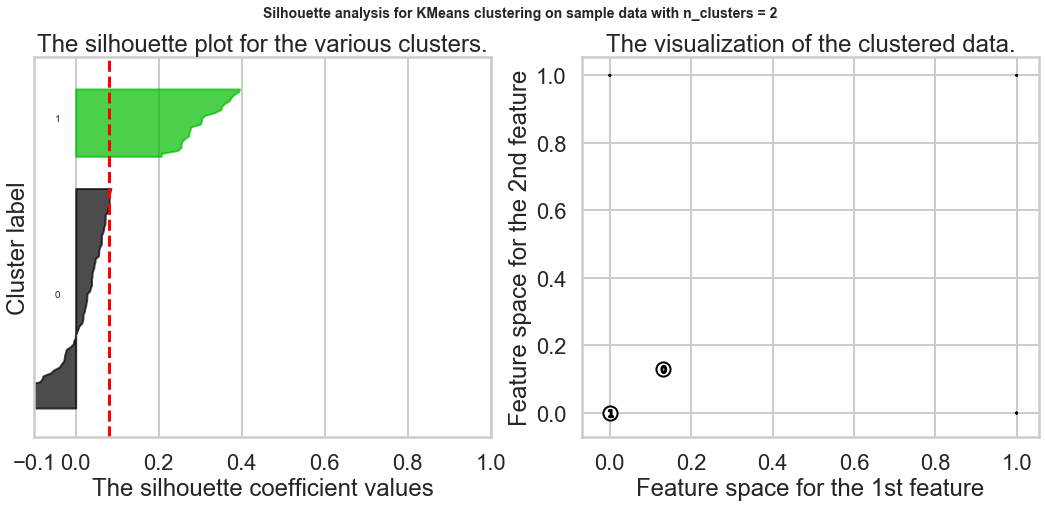

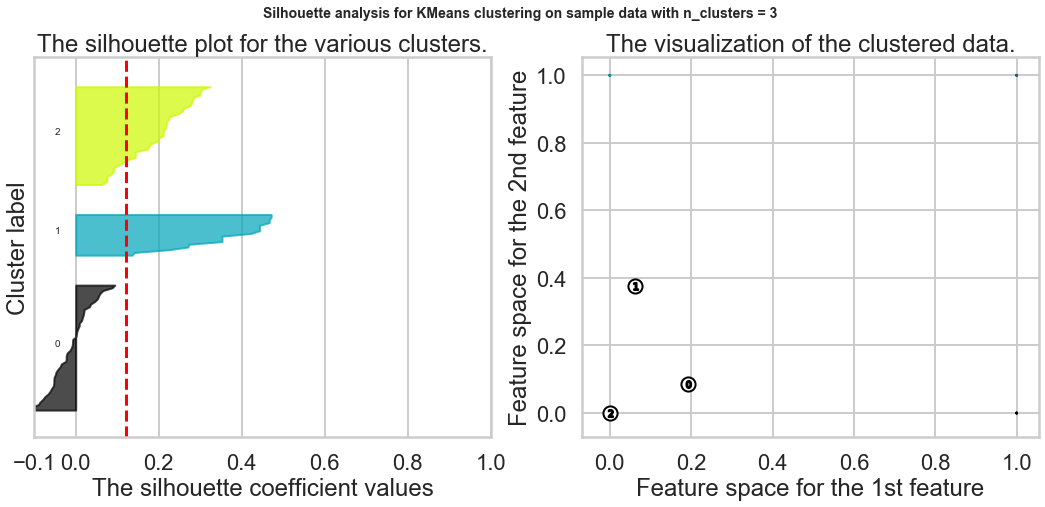

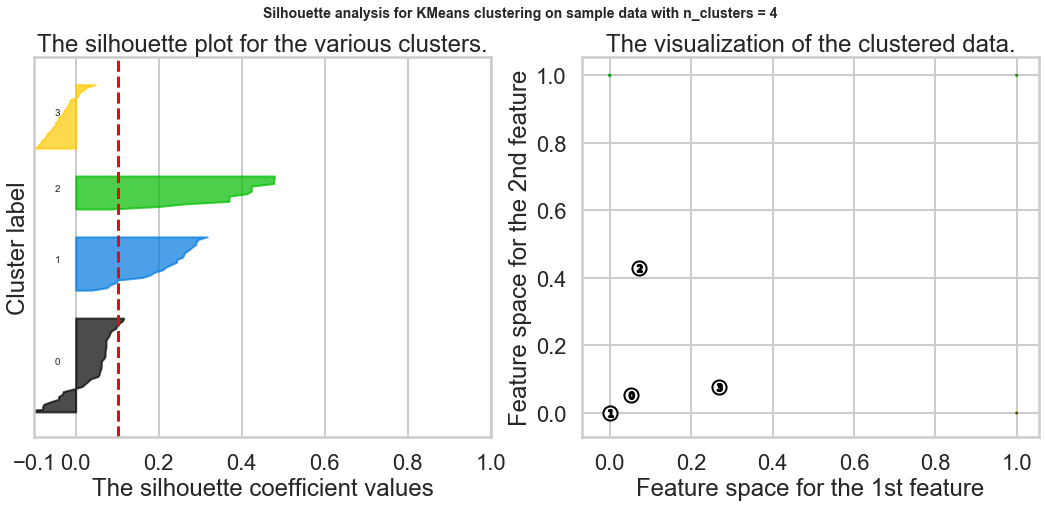

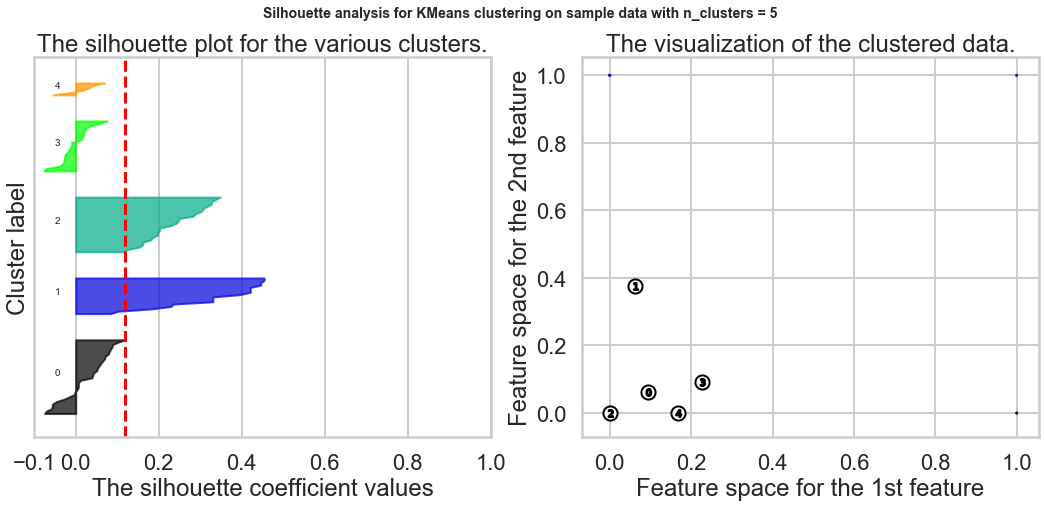

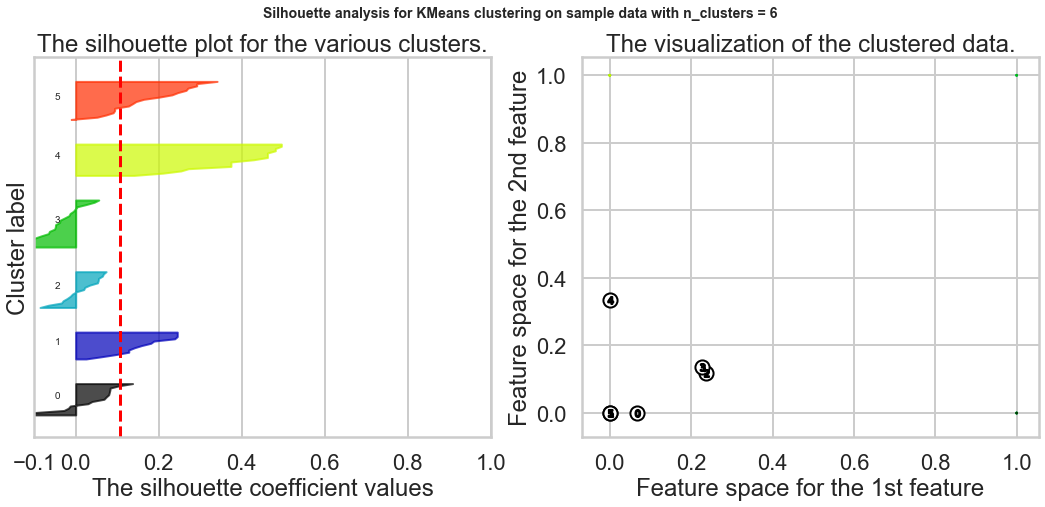

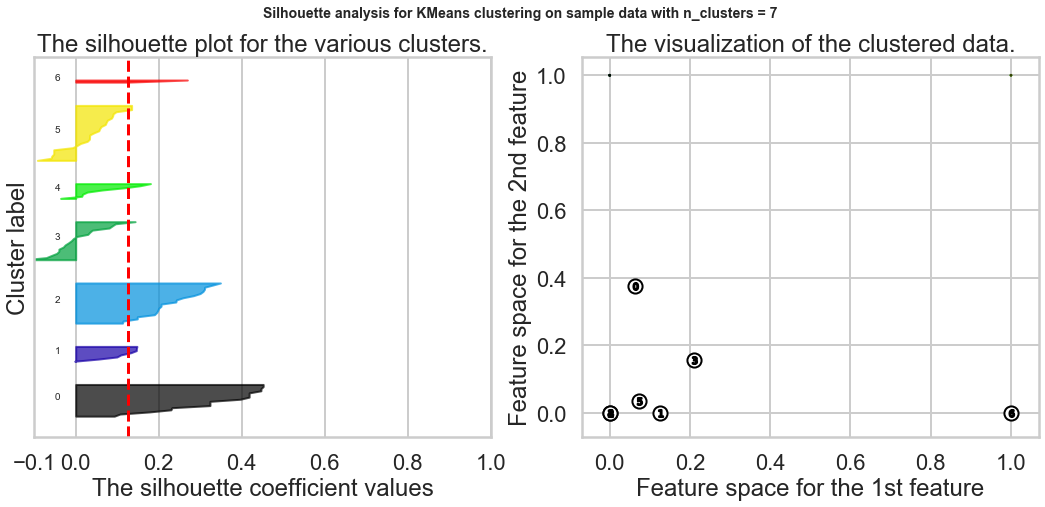

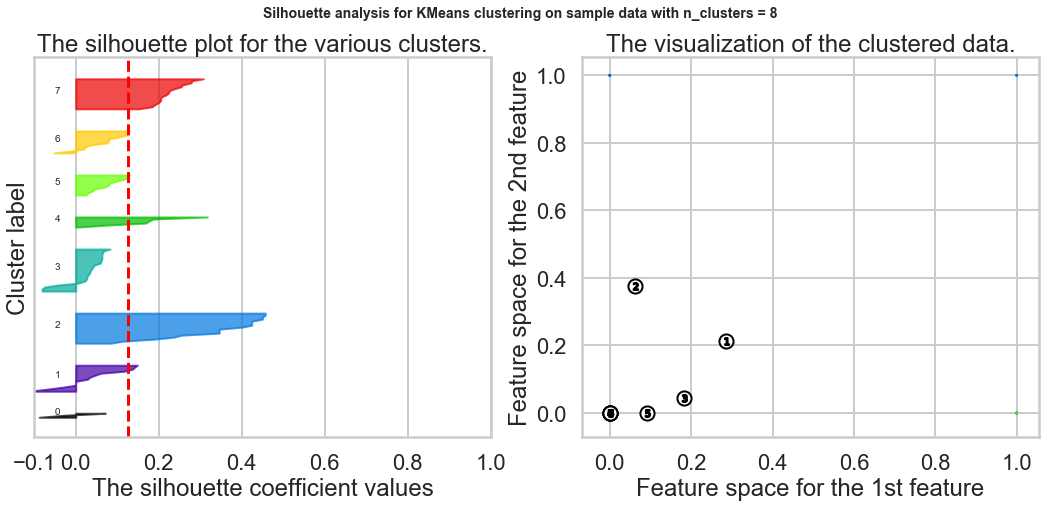

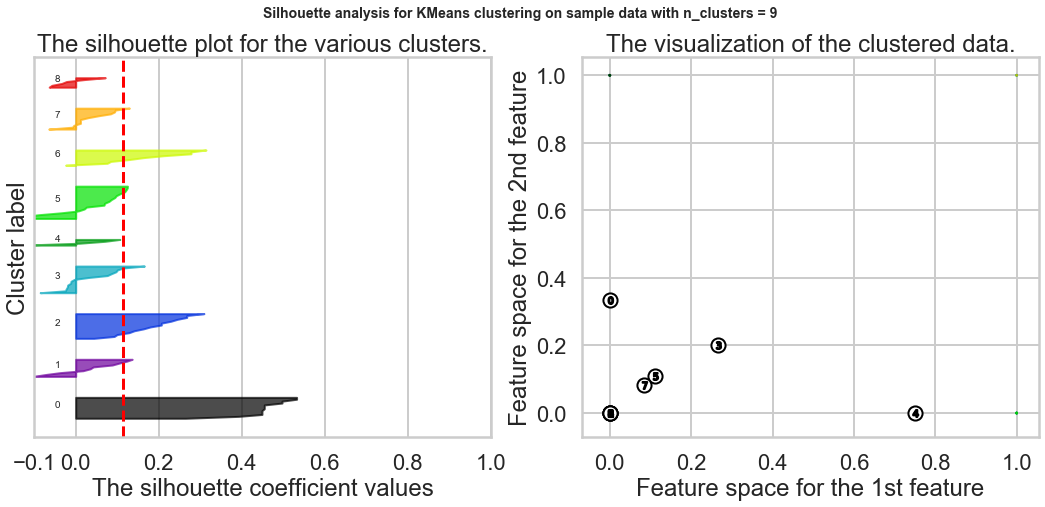

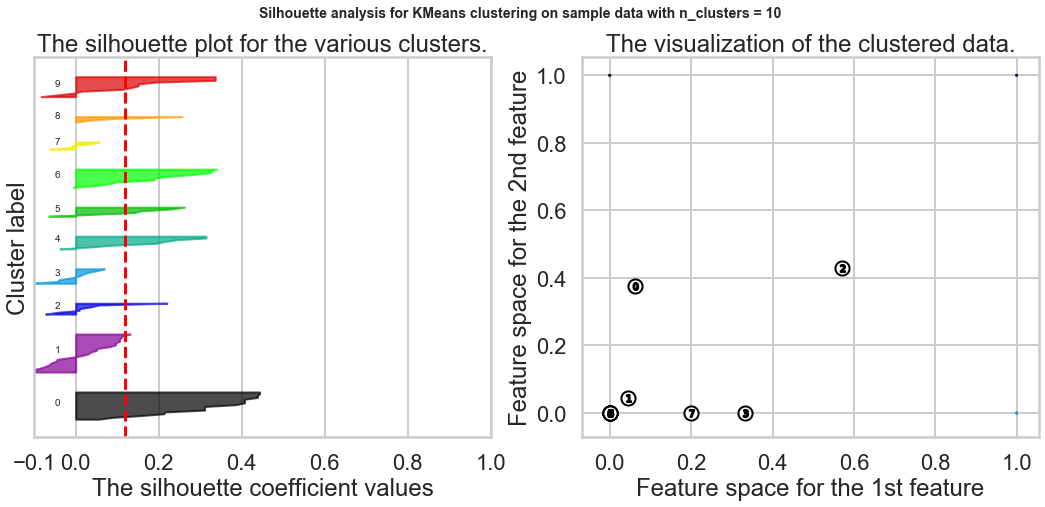

In [8]:
# Your turn.
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm # colormap

# Create a matrix called x_cols
x_cols = df_pivot.to_numpy() # create numpy array first
x_cols = np.matrix(x_cols) # then create a matrix

k_vals = range(2, 11) # k vals should be between 2 and 11

saved_values = [] # to save the values for laters

# Go thorugh all the k values
for k in k_vals: # for each value of k
    model = KMeans(n_clusters = k, random_state=33) # k means for that k
    model.fit(x_cols) # fit the data to the columns
    predict = model.predict(x_cols)
    score = silhouette_score(x_cols, predict)
    new_df = pd.DataFrame({'k': k, 'score': score}, index=[0])
        # make a new df 
    saved_values.append(new_df) # append the values
    
    # Time to figure out the plots
    fig, (ax1, ax2) = plt.subplots(1, 2) # we want two subplots
    fig.set_size_inches(18, 7) # make it a nice size

    ax1.set_xlim([-0.1, 1]) # set x axes
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (k + 1) * 10])
    
    # create sample silhouette values
    sample_silhouette_values = silhouette_samples(x_cols, predict)
    
    # start with a lower y value of 10
    y_lower=10
     
    # and iterate through the k values
    for i in range(k):  # for the range in 0 to k
        ith_cluster_silhouette_values = \
            sample_silhouette_values[predict == i] # get the values in the silhouette
            # where the prediction value == i (the value in the k range)

        ith_cluster_silhouette_values.sort() # sort the values

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
            # keep the shape of length
        y_upper = y_lower + size_cluster_i # and add the lower side to this cluseter
            # to get the y-upper limit

        color = cm.nipy_spectral(float(i) / k) # get a series of colors
        ax1.fill_betweenx(np.arange(y_lower, y_upper), # and fill the values between the
                        # y lower and higher limits
                          0, ith_cluster_silhouette_values, # for the respected values
                          facecolor=color, edgecolor=color, alpha=0.7) # aesthetics

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Make the labels pretty
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=score, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]) # set to match the range of limits

    colors = cm.nipy_spectral(predict.astype(float) / k) # define new colors for the scatter
        # plot that uses data pts.
    ax2.scatter(np.array(x_cols[:, 0]), np.array(x_cols[:, 1]), marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
        # build a scatter plot with the first two features of x-cols.

    # Labeling the clusters
    centers = model.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers): # go through each center
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
            # and add to the scatter plot

    # Make the labels look nice
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')
    
plt.show() # show the plot
    
saved_values = pd.concat(saved_values).reset_index(drop=True)
    # concat to save the values as a pd dataframe

In [9]:
# Print the saved values from the mean silhouette for each value of k
print(saved_values)

    k     score
0   2  0.079267
1   3  0.121331
2   4  0.102510
3   5  0.117705
4   6  0.106319
5   7  0.126867
6   8  0.125443
7   9  0.114545
8  10  0.118537


It seems like the k with the greatest silhouette score is k = 7 (score = 0.126867). This is the same as what I got in the elbow analysis, but it feels more legitimate here, because I'm not estimating a slope angle, but rather looking at distinct score numbers. However, each of the score values show no real correlation, according to the table above.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

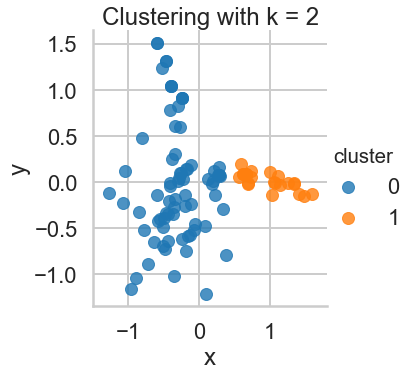

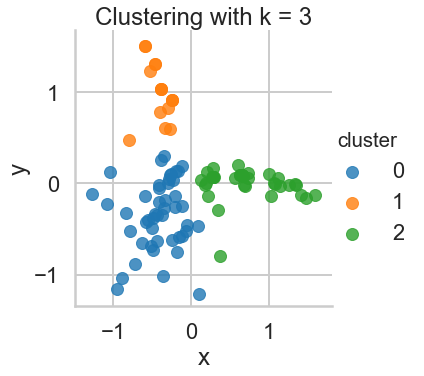

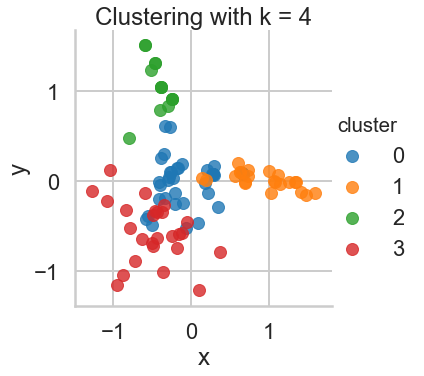

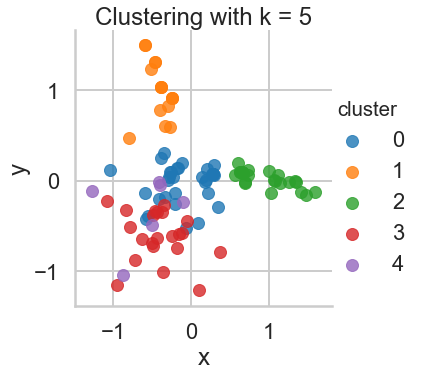

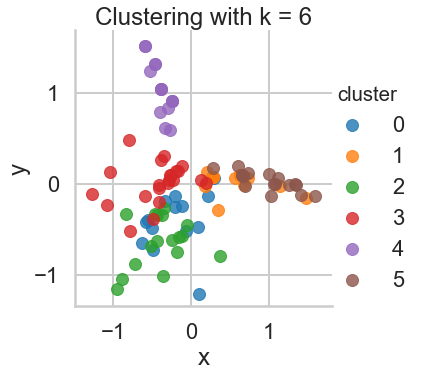

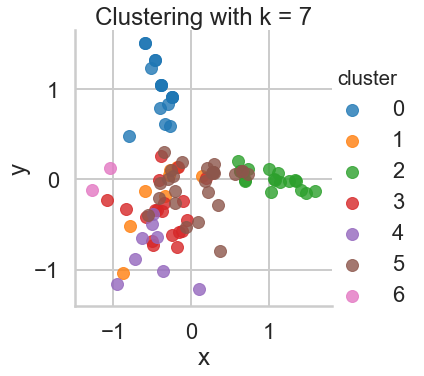

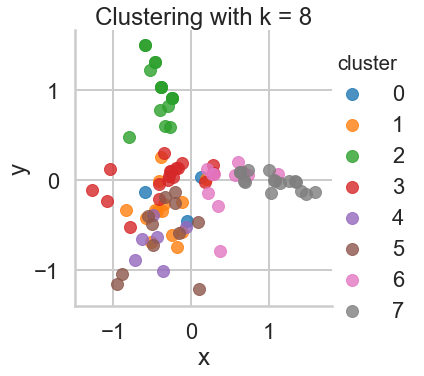

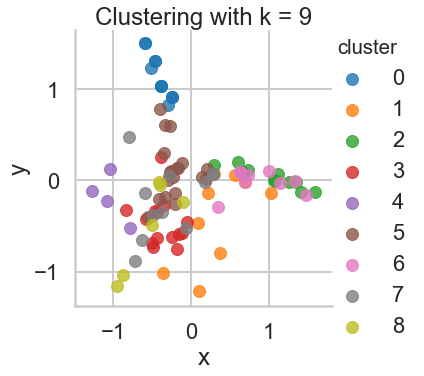

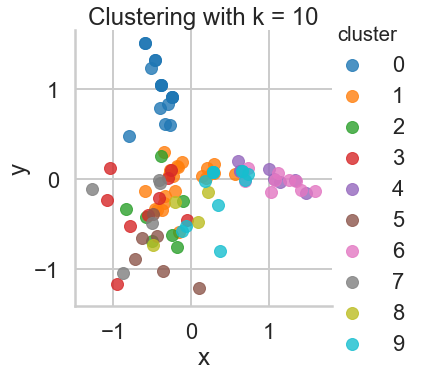

In [10]:
#your turn
# Import the packages
from sklearn.decomposition import PCA
import seaborn as sns

df_pivot = df_pivot.reset_index() # so that we can have customer name

# Re-do with loop for k
for k in k_vals: # for each kvalue
    kmeans = KMeans(n_clusters=k, random_state=33) # set the k 
    kmeans.fit(x_cols) # fit the data
    labels = kmeans.labels_ # and retrieve the labels... (clusters)

    pca = PCA(n_components=2) # run a pca with 2 components
    transformed = pca.fit_transform(x_cols) # fit_transform the dataset

    new_dat = pd.DataFrame(transformed) # and start building new df
    new_dat['labels'] = labels # add labels
    new_dat['customer_name'] = df_pivot['customer_name'] # add customers
    new_dat = new_dat[['customer_name', 'labels', 0, 1]] # re-order columns
    new_dat.columns = ['customer_name', 'cluster', 'x', 'y'] # and rename appropriately
    
    # Time to plot it
    sns.lmplot('x', 'y', data=new_dat, fit_reg=False, hue='cluster') # plot x vs y
        # and color by cluster
    plt.title('Clustering with k = ' + str(k)) # add title
    plt.show() # show plot

Honestly, these plots look best when k=4, there are four clear groups, and they seem to be spread apart enough that we could somewhat categorize them (we might even be able to turn this into a supervised project by using the aribtrarily assigned values produced by the clusters when k=4).

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

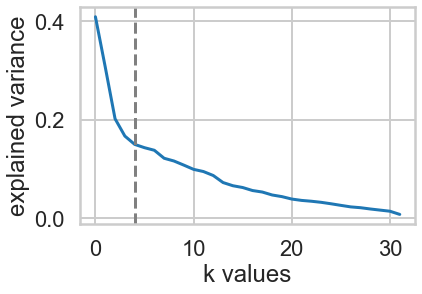

In [11]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA() # initialize a pca
pca.fit(x_cols) # fit to the x-values

# Do the rest on your own :)
ratio = pca.explained_variance_ # get the explained variance
plt.plot(ratio) # plot the ratios
plt.xlabel('k values') # fix labels
plt.ylabel('explained variance') # fix labels
plt.axvline(4, color='gray', linestyle='dashed') # add dashed line where
    # i think the data slope slows down
plt.show() # show plot.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


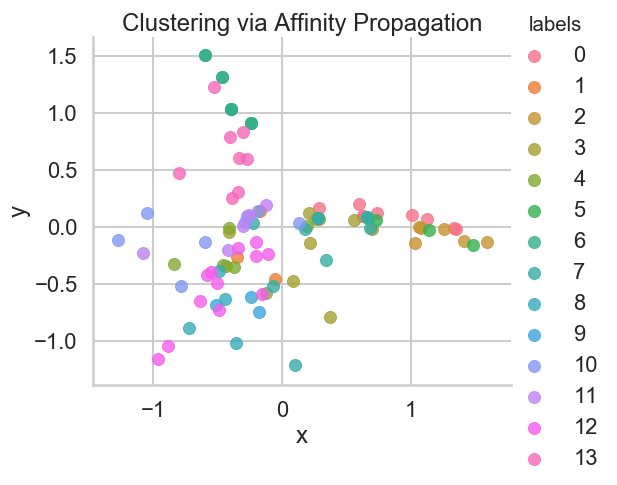

In [12]:
# Your turn
# Clustering via affinity propagation
# import packages
from sklearn.cluster import AffinityPropagation 

ap = AffinityPropagation() # set up instance
ap.fit(x_cols) # fit to the data
labels = ap.labels_ # save predicted clusters

# Continue with PCA
pca = sklearn.decomposition.PCA(n_components=2) # 2 comp
pca.fit(x_cols) # fit to the data
new_dat= pd.DataFrame(pca.transform(x_cols)) # transform the data
new_dat.columns=['x','y'] # rename cols
new_dat['customer_name'] = df_pivot['customer_name'] # add customer
new_dat['labels']=labels # add predicted clusters

sns.lmplot(x='x', y='y', hue='labels', data=new_dat, fit_reg=False, height=6, aspect=1.25)
    # plot
plt.title('Clustering via Affinity Propagation') # add title
plt.show() # show plot

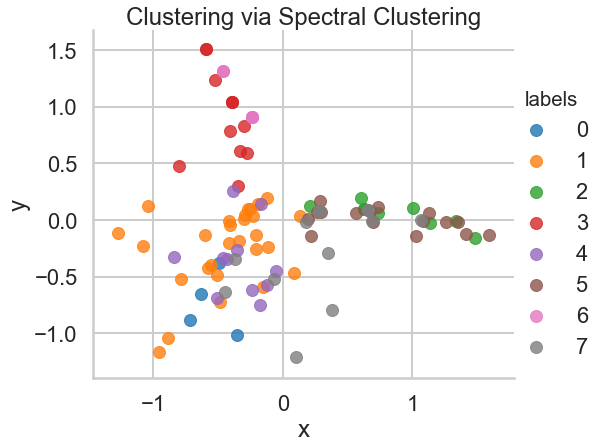

In [13]:
# Clustering via spectral clustering
# import packages
from sklearn.cluster import SpectralClustering

sc = SpectralClustering() # set up instance
sc.fit(x_cols) # fit to the data
labels = sc.labels_ # save predicted clusters

# Continue with PCA
pca = sklearn.decomposition.PCA(n_components=2) # 2 comp
pca.fit(x_cols) # fit to the data
new_dat= pd.DataFrame(pca.transform(x_cols)) # transform the data
new_dat.columns=['x','y'] # rename cols
new_dat['customer_name'] = df_pivot['customer_name'] # add customer
new_dat['labels']=labels # add predicted clusters

sns.lmplot(x='x', y='y', hue='labels', data=new_dat, fit_reg=False, height=6, aspect=1.25)
    # plot
plt.title('Clustering via Spectral Clustering') # add title
plt.show() # show plot

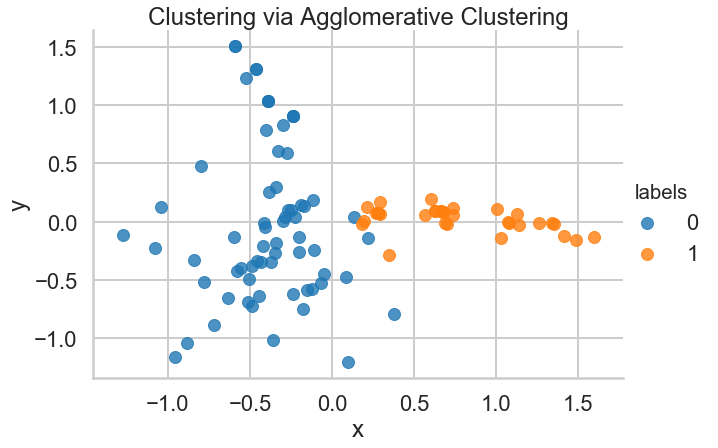

In [14]:
# Clustering via Agglomerative clustering
# import packages
from sklearn.cluster import AgglomerativeClustering

ag = AgglomerativeClustering() # set up instance
ag.fit(x_cols) # fit to the data
labels = ag.labels_ # save predicted clusters

# Continue with PCA
pca = sklearn.decomposition.PCA(n_components=2) # 2 comp
pca.fit(x_cols) # fit to the data
new_dat= pd.DataFrame(pca.transform(x_cols)) # transform the data
new_dat.columns=['x','y'] # rename cols
new_dat['customer_name'] = df_pivot['customer_name'] # add customer
new_dat['labels']=labels # add predicted clusters

sns.lmplot(x='x', y='y', hue='labels', data=new_dat, fit_reg=False, height=6, aspect=1.5)
    # plot
plt.title('Clustering via Agglomerative Clustering') # add title
plt.show() # show plot

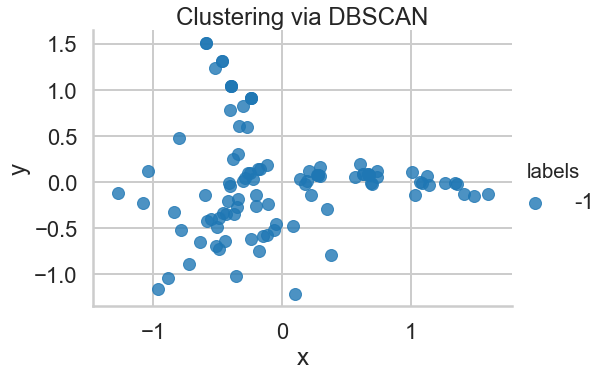

In [15]:
# Clustering via DBSCAN
# import packages
from sklearn.cluster import DBSCAN

dbs = DBSCAN() # set up instance
dbs.fit(x_cols) # fit to the data
labels = dbs.labels_ # save predicted clusters

# Continue with PCA
pca = sklearn.decomposition.PCA(n_components=2) # 2 comp
pca.fit(x_cols) # fit to the data
new_dat= pd.DataFrame(pca.transform(x_cols)) # transform the data
new_dat.columns=['x','y'] # rename cols
new_dat['customer_name'] = df_pivot['customer_name'] # add customer
new_dat['labels']=labels # add predicted clusters

sns.lmplot(x='x', y='y', hue='labels', data=new_dat, fit_reg=False, height=5, aspect=1.5)
    # plot
plt.title('Clustering via DBSCAN')
plt.show() # show plot

By using just the default parameters for each clustering method (not specifying them within the initialization), it seems like agglomerative clustering might fit the data the most. Affinity propagation (definitely) and spectral clustering (almost) seem to overfit the data; there are several different clusters but they all seem to overlap in some way. Alternatively, DBSCAN seems to under-fit the data; all data points are in the same cluster. Using Agglomerate clustering provides two clusters, which seem to make logical sense, as the first cluster has a high variance along the x axis and the y axis, while the second cluster is shifted to higher x values and has a much lower variance in regards to the y axis compared to the x axis. This would make sense if some offers were only given to people that had previously confirmed that they would take the deal, like top customers (lower variance around the y axis), whereas other deals may be given to many people simply by cold-calling or sending mail to all past and present customers, regardless of their level of participation. However, I think that all of the models could fit the data well if we were to do some hyperparameter testing like we did for k-means above.